# Truth Match Prob

We don't have the full truth record in our derivations (or Ntuples), so to ID PU tracks, we check if the truthMatchProb is < 0.75. However, this optimization was last done in Run 1, so might need to be reoptimized.

The truth match prob looks at the hits in common of a track with a truth probability to calculate this metric.  


$$P_{match} = \frac{10 \cdot N_{Pix}^{common} + 5 \cdot N_{SCT}^{common} + 1 \cdot N_{TRT}^{common}}{10 \cdot N_{Pix}^{track} + 5 \cdot N_{SCT}^{track} + 1 \cdot N_{TRT}^{track}}$$

In a higher PU region, there are more tracks that could be shared, etc, so since it's a denser enviornment, I think you would expect the $P_{match}$ distribution to *increase* as a function of $\mu$.

However, contrary to my intuition, the $P_{match}$ decreases as a function of $\mu$ (Valentina showed me one of these plots.)


**Table of Contents**
1. [Truth Match Prob definitions](#Pmatch_trkOrig)
2.

PF also wanted me to look into the $n_{trk}^{IP3D}$ distributions when I change this labelling scheme.

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot
from tqdm import tqdm
import glob 

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from root_to_np import get_sort_index, passJet, saveData, loadData, getdR, scale
from matplotlib.colors import LogNorm
from termcolor import colored

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
fname = "~/gpfs/FlavourTagPerformanceFramework/run/flav_Akt4EMTo.root"

myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]

In [3]:
myTree.keys()

[b'runnb',
 b'eventnb',
 b'mcchan',
 b'mcwg',
 b'avgmu',
 b'actmu',
 b'PVx',
 b'PVy',
 b'PVz',
 b'truth_PVx',
 b'truth_PVy',
 b'truth_PVz',
 b'njets',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_pt_orig',
 b'jet_eta_orig',
 b'jet_phi_orig',
 b'jet_E_orig',
 b'jet_LabDr_HadF',
 b'jet_DoubleHadLabel',
 b'jet_JVT',
 b'jet_m',
 b'jet_nConst',
 b'jet_dRiso',
 b'jet_truthMatch',
 b'jet_isPU',
 b'jet_aliveAfterOR',
 b'jet_aliveAfterORmu',
 b'jet_isBadMedium',
 b'jet_truthPt',
 b'jet_dRminToB',
 b'jet_dRminToC',
 b'jet_dRminToT',
 b'jet_dl1_pb',
 b'jet_dl1_pc',
 b'jet_dl1_pu',
 b'jet_dl1mu_pb',
 b'jet_dl1mu_pc',
 b'jet_dl1mu_pu',
 b'jet_dl1rnn_pb',
 b'jet_dl1rnn_pc',
 b'jet_dl1rnn_pu',
 b'jet_mv2c10',
 b'jet_mv2c10mu',
 b'jet_mv2c10rnn',
 b'jet_mv2c100',
 b'jet_mv2cl100',
 b'jet_ip2d_pb',
 b'jet_ip2d_pc',
 b'jet_ip2d_pu',
 b'jet_ip2d_llr',
 b'jet_ip3d_pb',
 b'jet_ip3d_pc',
 b'jet_ip3d_pu',
 b'jet_ip3d_llr',
 b'jet_ip2',
 b'jet_ip2_c',
 b'jet_ip2_cu',
 b'jet_ip2_nan',
 b'jet_ip2_c_n

In [4]:
jet_vars = ['jet_pt', 
            'jet_eta',
            'jet_aliveAfterOR', 
            'jet_aliveAfterORmu',
            'jet_JVT', 
            'jet_LabDr_HadF',
            'jet_pt_orig','jet_eta_orig','jet_phi_orig',
            'jet_nBHadr','jet_nCHadr',
            'jet_dRminToB','jet_dRminToC','jet_dRminToT']
#             'jet_dRiso'
#             'jet_nGhostBHadrFromParent','jet_nGhostCHadrFromParent',
#             'jet_nGhostCHadrFromParentNotFromB',
#             'jet_nGhostTauFromParent',
#             'jet_nGhostBHadr','jet_nGhostCHadr',
#             'jet_nGhostCHadrNotFromB','jet_nGhostTau']

trk_vars = ['jet_trk_ip3d_d0sig',
            'jet_trk_ip3d_z0sig',
            'jet_trk_ip3d_d0',
            'jet_trk_parent_pdgid',
            'jet_trk_pdg_id',
            'jet_trk_barcode',
            'jet_trk_ip3d_grade',
            'jet_trk_orig',
            "jet_trk_pt", "jet_trk_eta", "jet_trk_phi",
            "jet_trk_nInnHits","jet_trk_nNextToInnHits", 
            "jet_trk_nsharedBLHits","jet_trk_nsplitBLHits",
            "jet_trk_nPixHits","jet_trk_nsharedPixHits", "jet_trk_nsplitPixHits", 
            "jet_trk_nSCTHits", "jet_trk_nsharedSCTHits",
            "jet_trk_truthProb"
           ]


bH_child_barcode = myTree.array(b'jet_bH_child_barcode')
cH_child_barcode = myTree.array(b'jet_cH_child_barcode')

jet_arrays = myTree.arrays(jet_vars)
trk_arrays = myTree.arrays(trk_vars)

**Quick check:** Look at the barcode + $P_{match}$ for the PU tracks.

In [5]:
ievt = 0
ijet = 10

b = np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])
o = np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])
p = np.array(trk_arrays[b'jet_trk_truthProb'][ievt][ijet])

print("barcode",b[o==-1])
print("pmatch", p[o==-1])

barcode [-999 -999 -999 -999 -999 -999 -999 -999]
pmatch [1. 1. 1. 1. 1. 1. 1. 1.]


So this DAOD has 20k jets, so I should have enought statistics to do this study.

In [6]:
n_events = myTree.array(b'avgmu').shape[0]
n_events

20000

**Step 1:** Look at the truthMatchProb values for the "fake" tracks  <a id='Pmatch_trkOrig'></a>

I think I do need to loop through all of the particles to do this study, b/c I discriminate b/w the fake and real PU tracks by looking at the barcode match!

How did I do this in the `Barcode-Match` nb? 

- 0: HF (via the barcode match)
- -1: PU w/ no truth link
- 1: PU w/ a truth link & truthMatchProb < 0.75
- 2: fragmentation
- 3: GEANT

In [7]:
derived_trk_vars = ['jet_trk_newLabel', 'jet_trk_newOrig', 'jet_trk_newOrig_0.5']

output_jet_array = []
output_trk_array = {k:[] for k in trk_vars + derived_trk_vars}

Modify the `trk_orig` var to have functionality to break down the PU category into fakes and real PU tracks.

Call this new var `trk_newOrig`, and have it be
- 0: HF 
- -1: PU w/ no truth link
- 1: PU w/ a truth link & truthMatchProb < 0.75
- 2: fragmentation
- 3: GEANT

So I'm using the numbers to mean the same thing as before, I'm just using the HF definition from the `trk_orig` variable instead of using a barcode match!

It might also be interesting to c.f. these distributions to see how they are impacted by these differing definitions?

Recall: How is `trk_orig` defined rn?
- 0: HF, b-hadron
- 1: HF, c-hadron
- 2: fragmentation
- 3: GEANT  
- -1: PU

In [8]:
dataDir = '../../data'
subDir = 'mc16d_Topo_ttbar'

nJets = 8e4
mode = ''
nTrks = 15
sort_flag = 'sd0_rev'
tag = '_Pmatch'
filename = "{}/{}/jet_{}{}_{}trks_{}{}.h5".format(dataDir,subDir,nJetsTag(nJets),
                                                  mode,nTrks,sort_flag,tag)

filename

'../../data/mc16d_Topo_ttbar/jet_80k_15trks_sd0_rev_Pmatch.h5'

In [9]:
if os.path.exists(filename):

    # Just load in the data
    jet_df, trk_xr = loadData(filename,nJets)
    
else:    

    # Look at the Ntuples to get the data!
    for ievt in range(n_events):

        if ievt % 1000 == 0:
            print('Event {}'.format(ievt))
        
        # Jet loop
        n_jets = len(jet_arrays[b"jet_pt"][ievt])
        for ijet in range(n_jets):

            if not passJet(jet_arrays, trk_arrays, ievt, ijet):
                continue

            # Trk selection
            ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
            index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                         sort_type='sd0_rev' )

            '''
            Try a new way of assigning the labelling.
            - First look for the HF tracks
            - Create two separate PU categories
            - Then GEANT and fragementation categories proceed as normal
            '''

            # Create a np.array to store the output of this "new + improved" label 
            tlabels = np.zeros(np.sum(ip3d_mask)).astype(int)

            # Trk loop
            for itrk, (t_pdg, tbarcode, torig) in enumerate(zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                                  np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                                  np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list])):


                # Access the truth b + c hadron 
                barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                               (tbarcode in cH_child_barcode[ievt][ijet])

                if barcodeMatch:
                    tlabels[itrk] = 0

                elif t_pdg == -999:
                    tlabels[itrk] = -1
                else:
                    tlabels[itrk] = abs(torig)

                                     
            # Save relevant info
            jetList = [jet_arrays[jvar.encode()][ievt][ijet] for jvar in jet_vars]
            output_jet_array.append(np.array(jetList).reshape(1,-1))
            for tvar in trk_vars:
                output_trk_array[tvar].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[ip3d_mask][index_list] )

            output_trk_array['jet_trk_newLabel'].append(tlabels)

            trk_newOrig = output_trk_array['jet_trk_orig'][-1].copy()

            # HF mask
            trk_newOrig[trk_newOrig == 1] = 0

            # PU - all I need to do is muliply the real PU tracks by -1
            PU_mask = (trk_newOrig == -1)
            realPU = (output_trk_array['jet_trk_newLabel'][-1] == 1)
            trk_newOrig[PU_mask & realPU] *= -1 

            output_trk_array['jet_trk_newOrig'].append(trk_newOrig)
      
    
            # Modify the PU definition by if the truth link exists, checking
            # if the Pmatch is < 0.5 for the jet_trk_newOrig tag
            val = trk_newOrig.copy()
            
            for itrk, (tNewOrig,tbarcode,tPmatch,tNewLabel) in enumerate(zip(trk_newOrig,
                                                                             output_trk_array['jet_trk_barcode'][-1],
                                                                             output_trk_array['jet_trk_truthProb'][-1],
                                                                             output_trk_array['jet_trk_newLabel'][-1])):
                # Only modify the tracks where the 
                if (tNewOrig == 1) & (tPmatch < 0.75):
                    # Check for the GEANT barcode
                    if tbarcode > 2e5:
                        val[itrk] = 3
                        
                    # Check for the HF barcode match (how I'm implementing the truth match)
                    elif tNewLabel == 0:
                        val[itrk] = 0
                    else:
                        val[itrk] = 2
            
            output_trk_array['jet_trk_newOrig_0.5'].append(trk_newOrig)
        
    # Outside fo the event loop: Go from lists of np arrays to the df + xr
    jet_df, trk_xr  = saveData(output_jet_array, output_trk_array, jet_vars, trk_vars+derived_trk_vars, 
                               nTrks, subDir=subDir,sort_flag=sort_flag, mode=mode, 
                               dataDir=dataDir,tag=tag)        

The requested sd0_rev sort was already implemented


I'm going to *save* this processed Ntuple for future studies that I might want to do!

In [10]:
X = trk_xr.values

pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.LabDr_HadF.replace(pdg_to_class).values

Look at $P_{match}$ for these two track labelling schemes

In [11]:
1/20

0.05

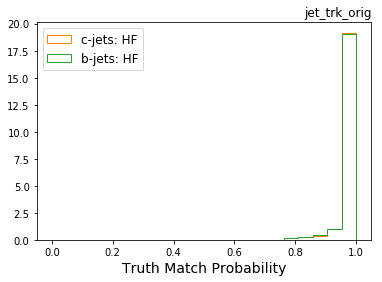

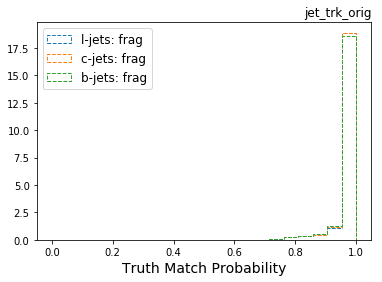

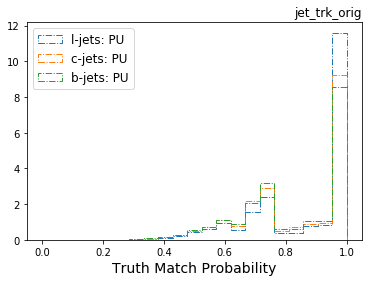

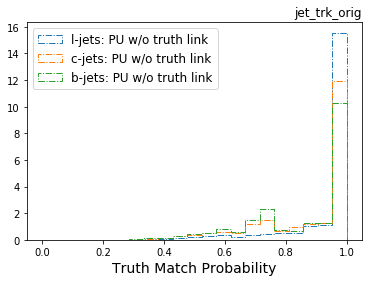

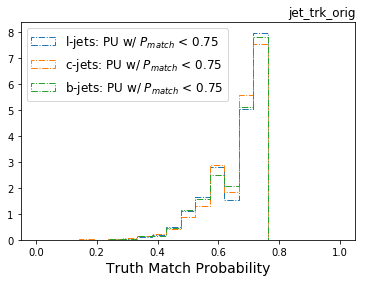

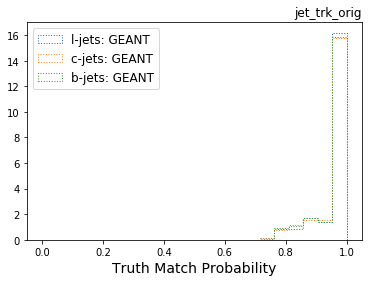

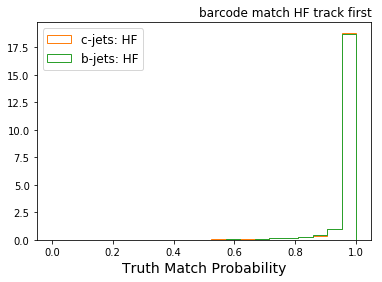

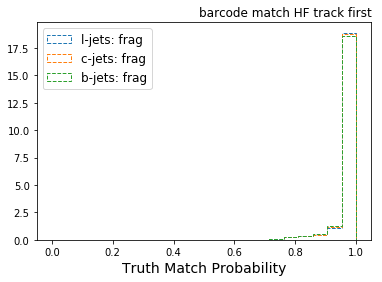

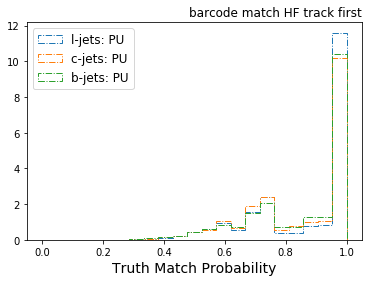

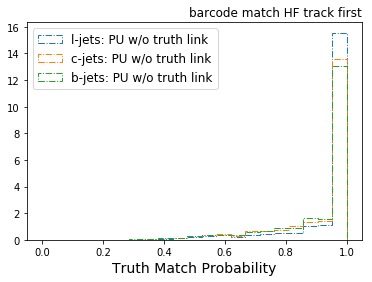

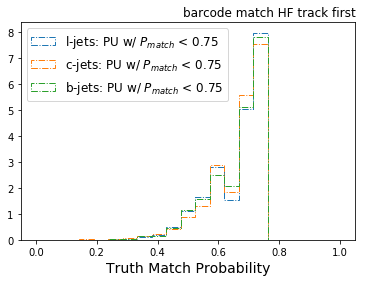

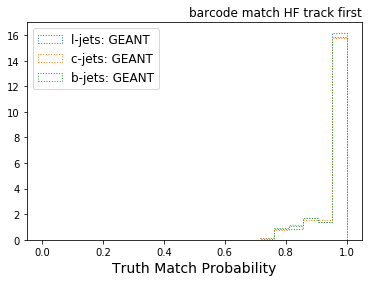

In [12]:
# Get the mask since all of the truth labels are track level variables
ones = np.ones_like(X[:,:,0])
y_trks = ones * y.reshape(-1,1)

# The jet_trk_orig var
o1_trks = ones * trk_xr.loc[:,:,'newOrig'].values

# Barcode match the HF assignment first
o2_trks = ones * trk_xr.loc[:,:,'newLabel'].values

mask = getTrkMask(X)

# This mask selects the non-masked tracks in the jet
y_trks = y_trks[mask]
o1_trks = o1_trks[mask]
o2_trks = o2_trks[mask]
  
#for v, xlabel, nBins, myRange in zip(xr_vars,xlabels,var_bins,var_ranges):

v = 'truthProb'
xlabel = 'Truth Match Probability'
nBins = 21
myRange = (0,1)

# Access the non-masked trks in the jet for this trk feature
var = trk_xr.loc[:,:,v].values[mask]


for o_trks, subDir, text in zip([o1_trks, o2_trks],
                                ['mc16d_Topo_ttbar','newTrkLabel'],
                                ['jet_trk_orig','barcode match HF track first']):

    for oi, orig_label, orig_tag, l in zip([0,2,(-1,1),-1,1,3],
                                           ['HF','frag','PU','PU w/o truth link','PU w/ $P_{match}$ < 0.75','GEANT'],
                                           ['HF','frag','PU','PU_noTruth','PU_truthLink','GEANT'],
                                           ['-', '--', '-.', '-.', '-.', ':']):

        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)

        plt.figure()

        for yi, flav in zip(range(3), ['l','c','b']):

            if (yi == 0) and (oi == 0):
                continue
            
            plt.hist(var[orig_mask & (y_trks == yi)],
                     range=myRange,bins=nBins,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,orig_label))

        plt.legend(loc='upper left',fontsize=12)  
        plt.xlabel(xlabel,fontsize=14)  
        plt.title(text,loc='right',fontsize=12)
        
        plt.savefig('../../figures/{}/{}_{}.pdf'.format(subDir,v,orig_tag))
        plt.show()
        


Now that I have access to *both* of these distributions, I think I'm going to try overlaying them to understand how much I actually gained by doing the HF assignment first through this barcode match.

Make the plots like you did in the `Barcode-Match` notebook!

In [14]:
xr_vars = ['sd0','sz0','ip3d_d0','orig',
           'pt','eta',
           'nInnHits','nsharedBLHits','nsplitBLHits',
           'nNextToInnHits',
           'nPixHits','nsharedPixHits','nsplitPixHits',
           'nSCTHits','nsharedSCTHits','truthProb']

xlabels = ['$s_{d0}$', '$s_{z0}$', 
           '$d_0$ [mm]','jet_trk_orig',
           '$p_T$ [GeV]','$\eta$',
           "# of L0 hits","# of shared hits in L0","# of split hits in L0",
           "# of L1 hits", 
           "# of pixel hits","# of shared pixel hits","# of split pixel hits",
           "# of SCT hits","# of shared SCT hits",'Truth Match Probability'
          ]

var_bins = [50,50,50,5,
            50,20,
            5,5,5,5,
            10,10,10,
            21,21,21]

var_ranges = [(-10,10),(-10,10),(-1,1),(-1.5,3.5),
              (0,30),(-2.5,2.5),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (-0.5,20.5),(-0.5,20.5),(0,1)]


legend_loc = ['upper left','upper left','upper left','upper right',
              'upper right','upper right',
              'upper right','upper right','upper right',
              'upper right','upper right','upper right','upper right',
              'upper right','upper right','upper left']

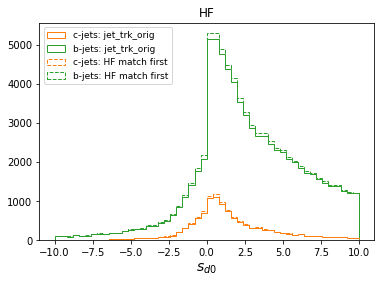

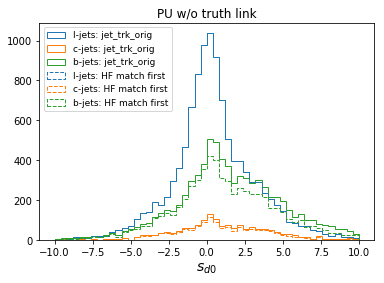

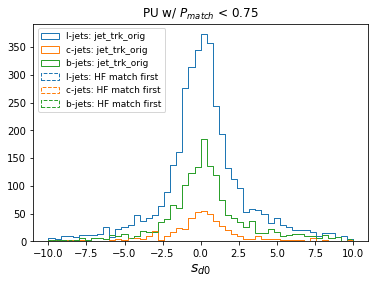

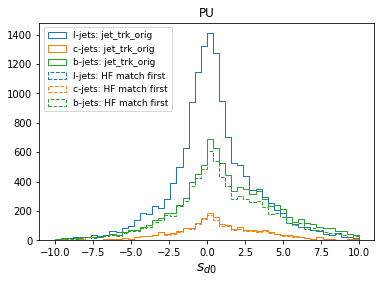

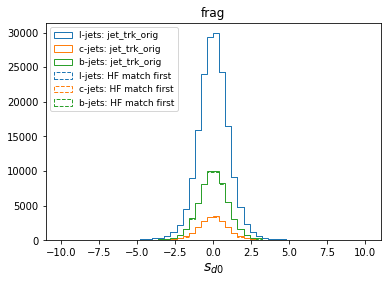

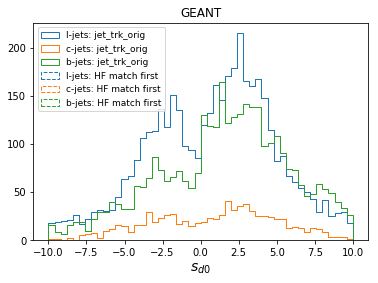

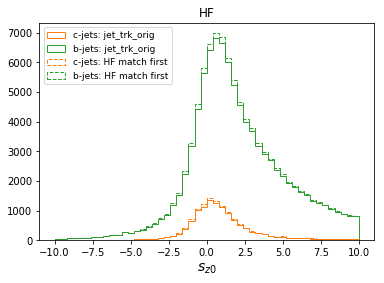

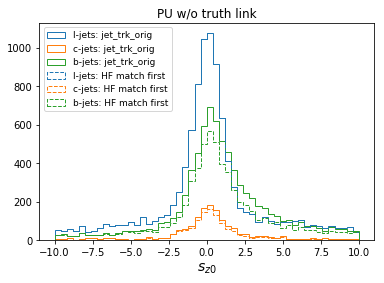

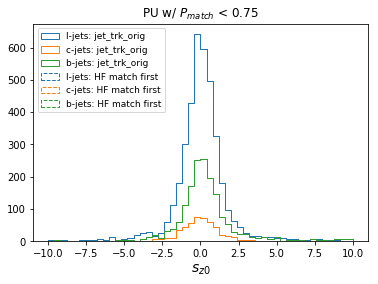

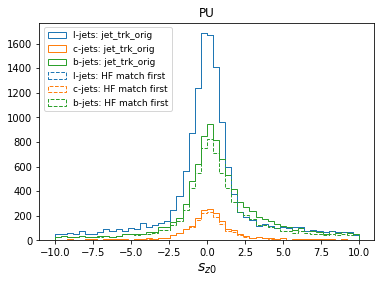

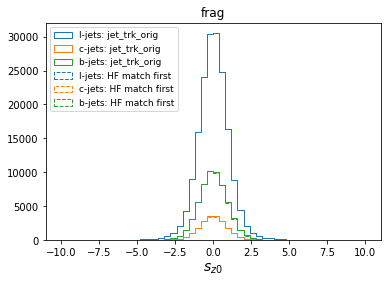

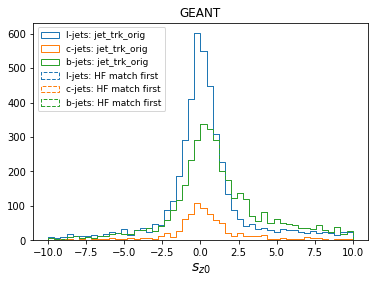

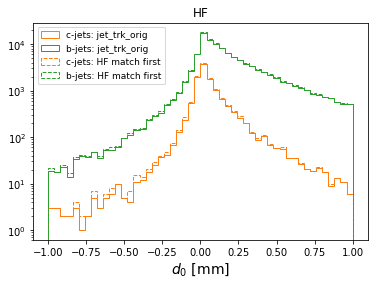

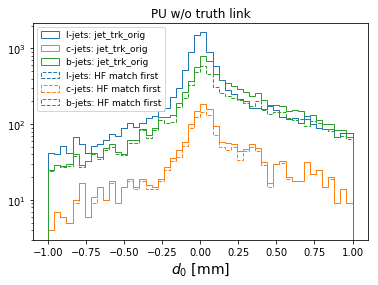

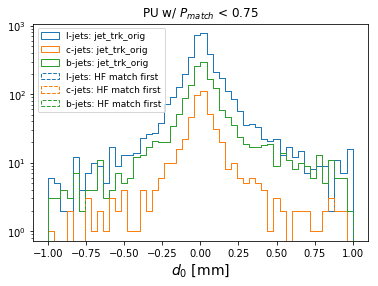

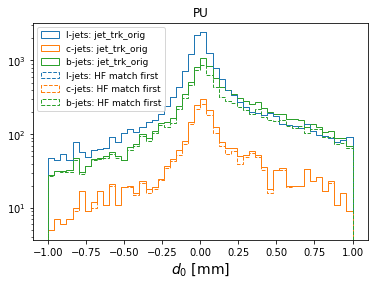

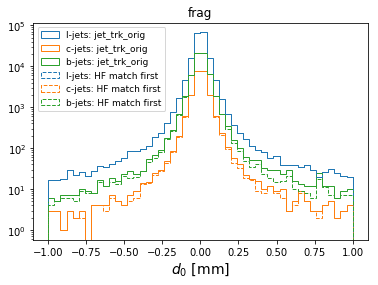

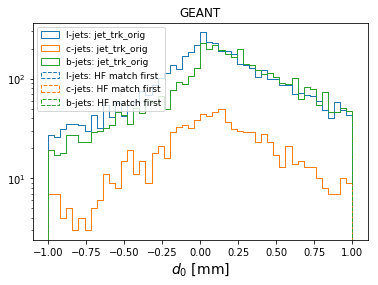

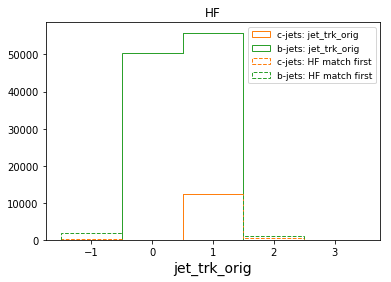

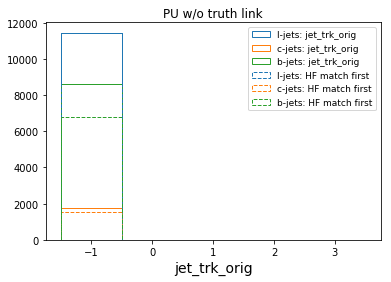

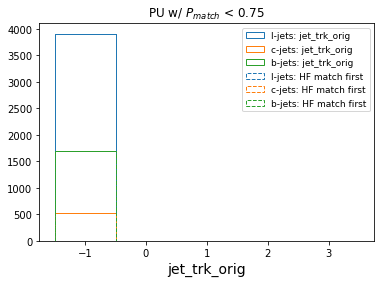

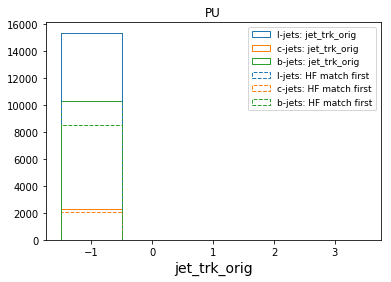

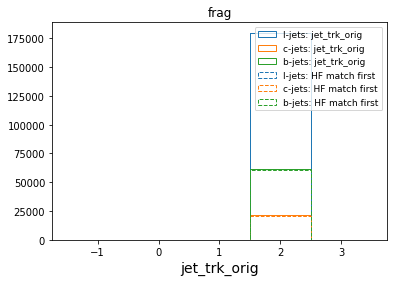

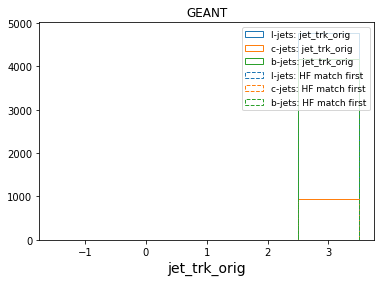

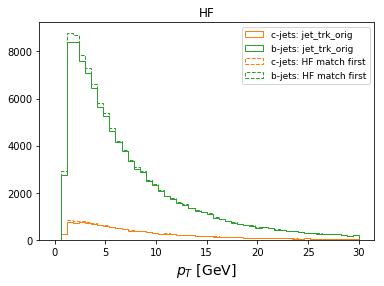

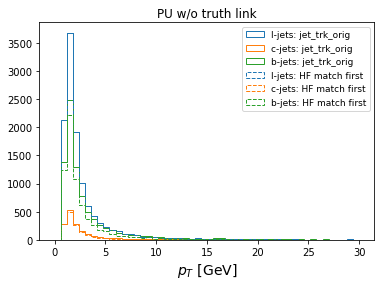

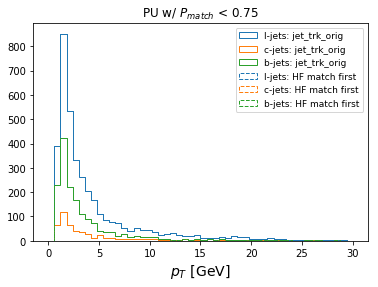

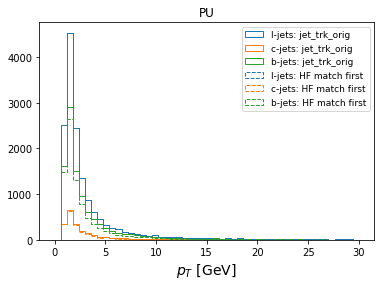

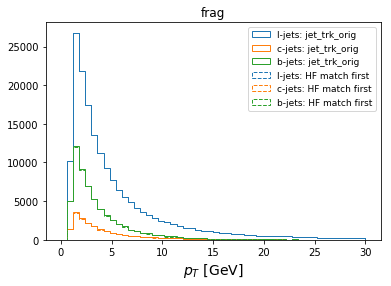

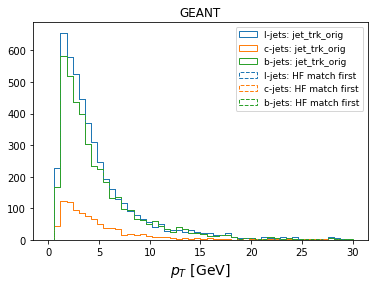

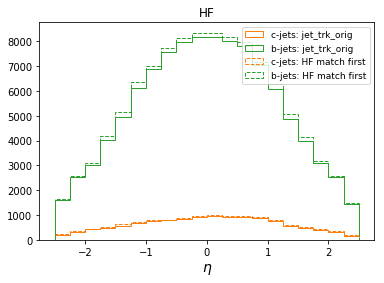

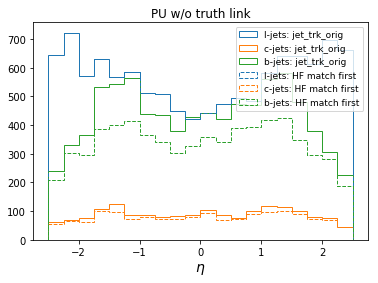

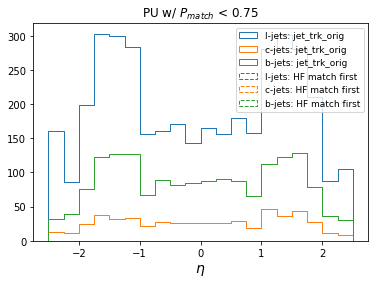

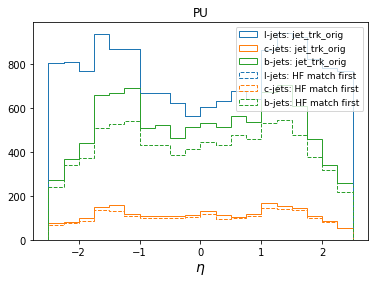

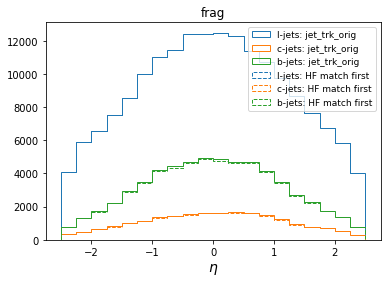

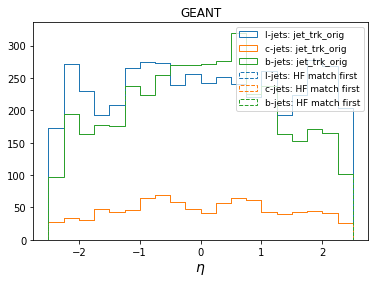

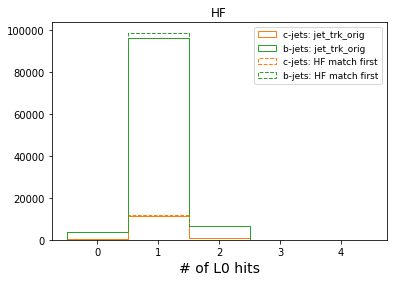

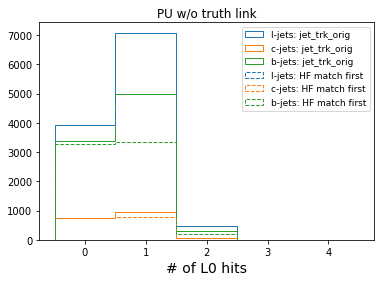

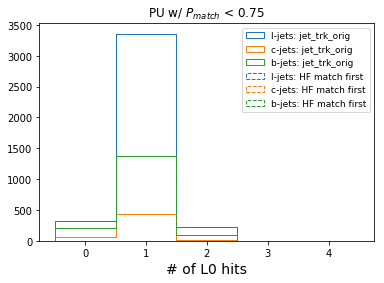

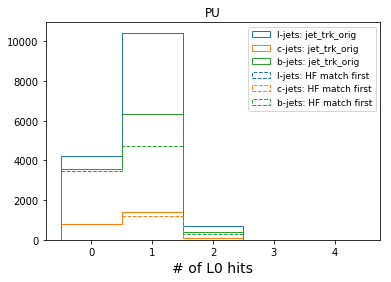

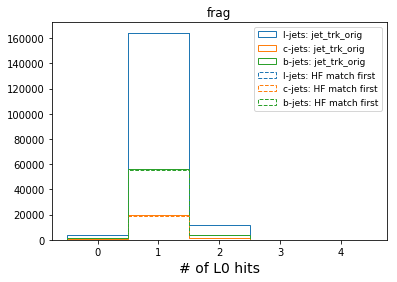

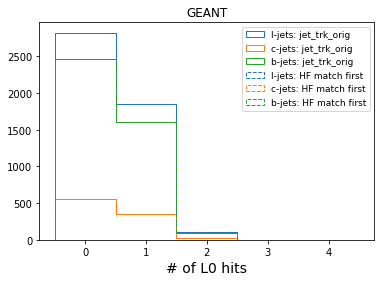

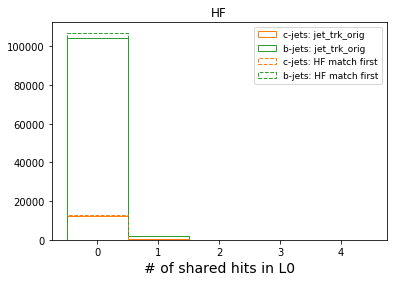

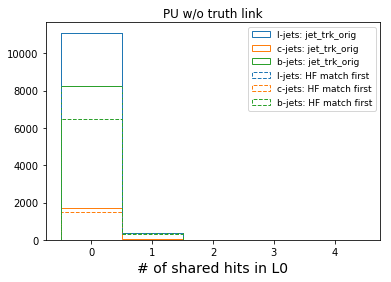

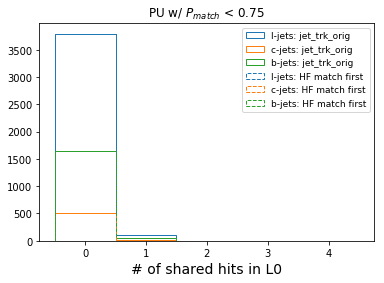

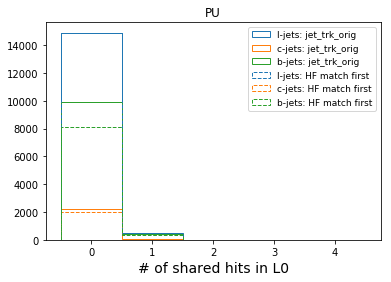

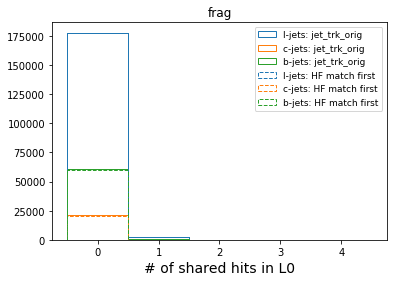

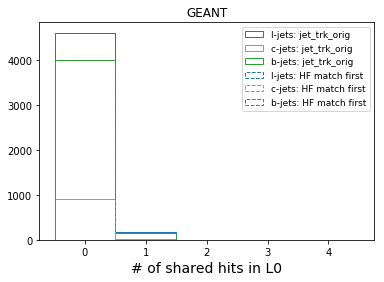

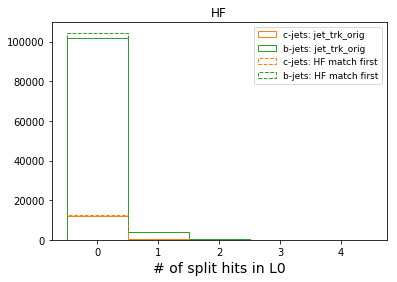

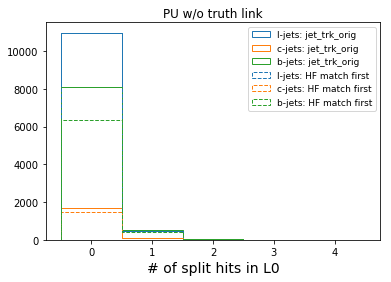

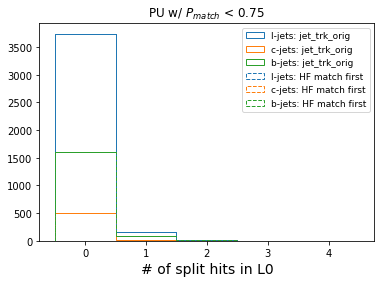

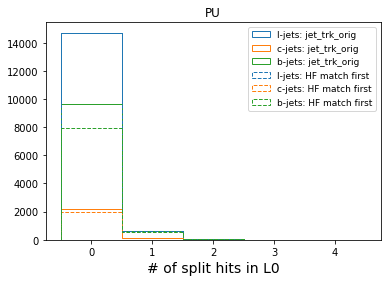

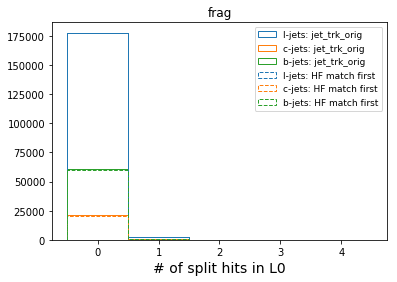

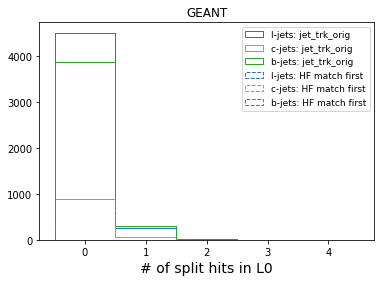

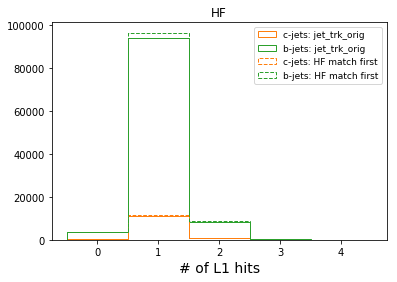

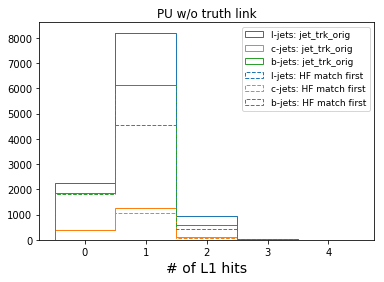

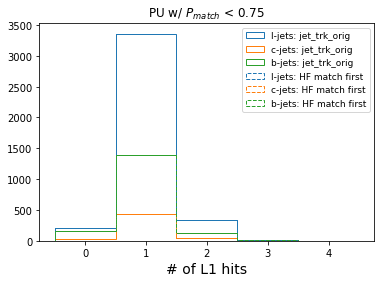

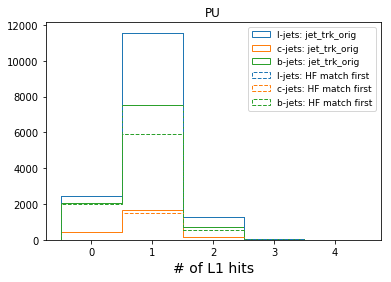

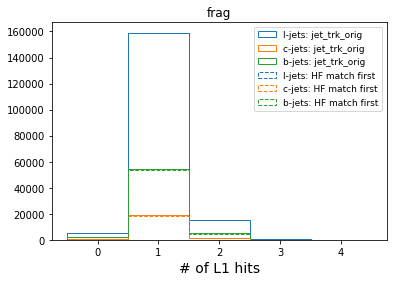

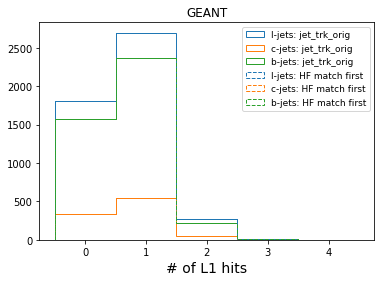

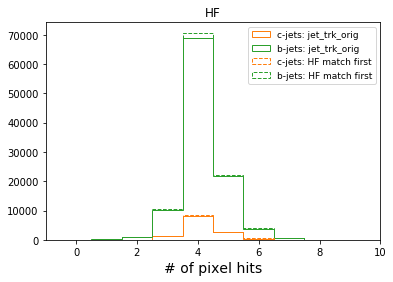

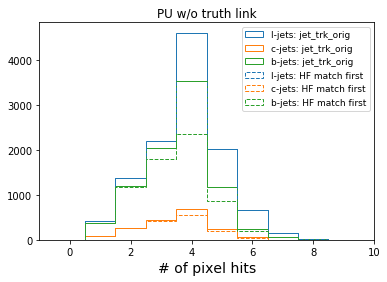

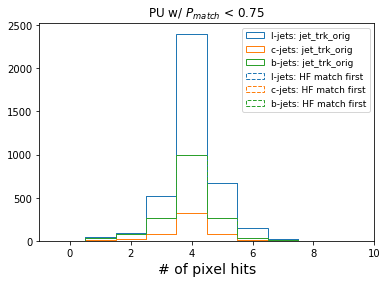

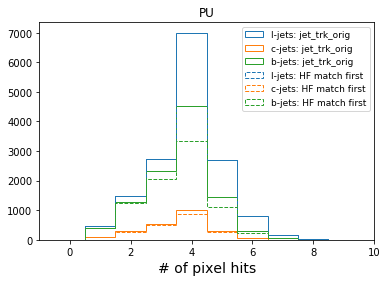

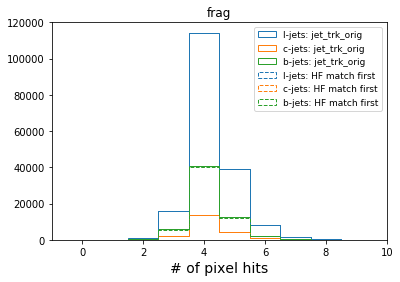

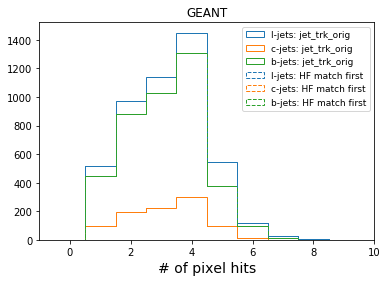

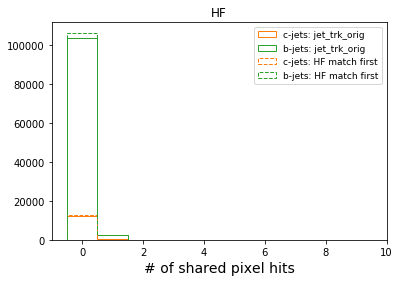

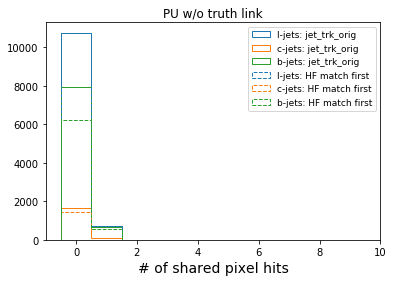

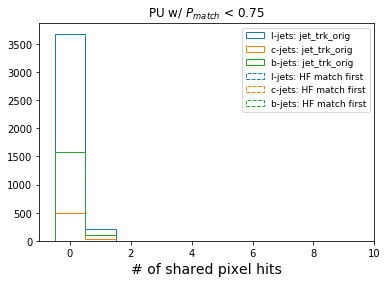

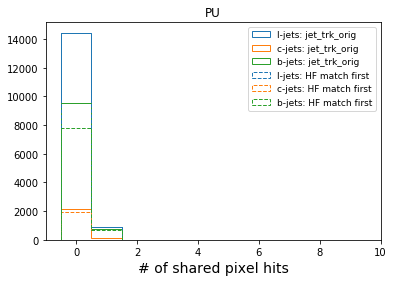

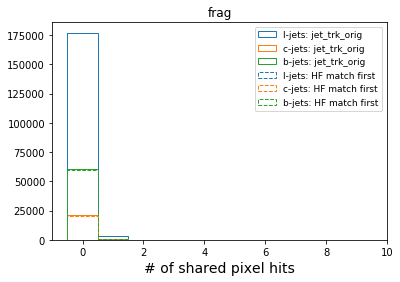

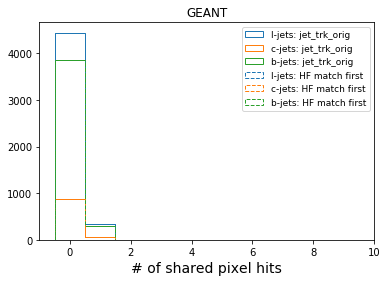

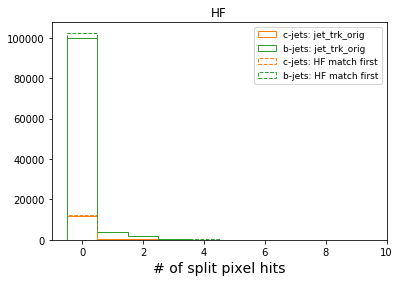

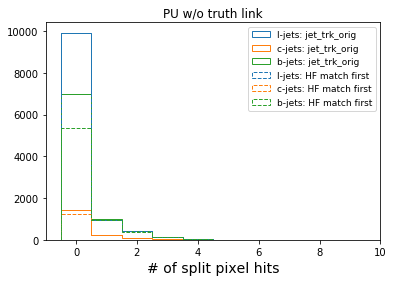

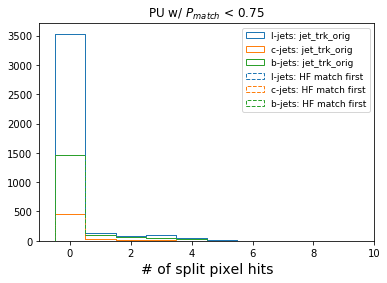

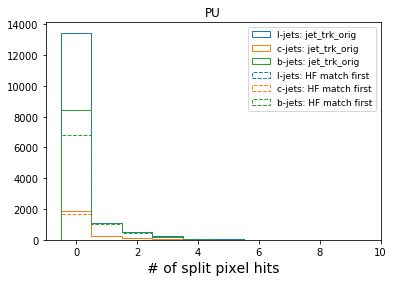

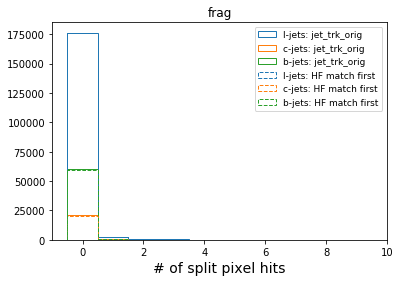

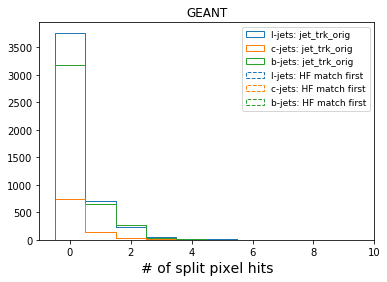

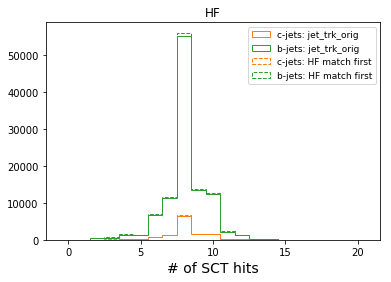

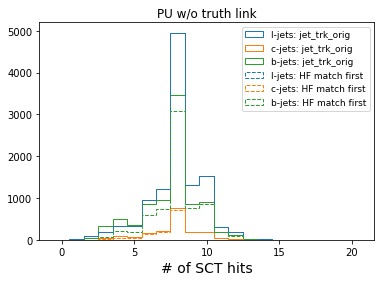

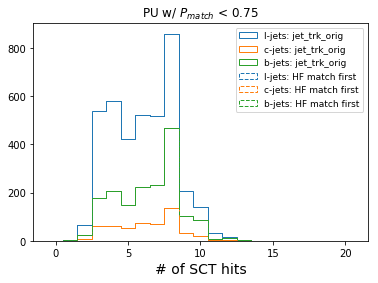

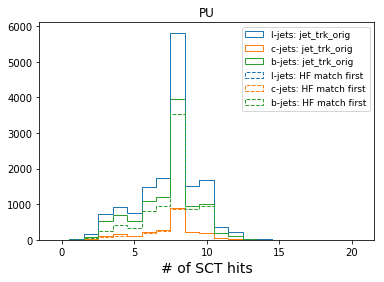

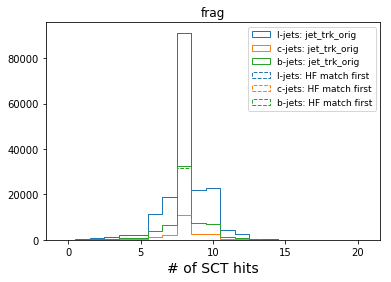

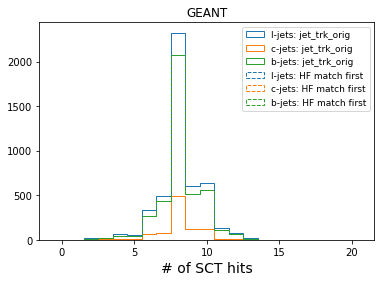

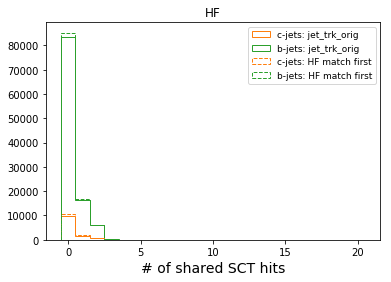

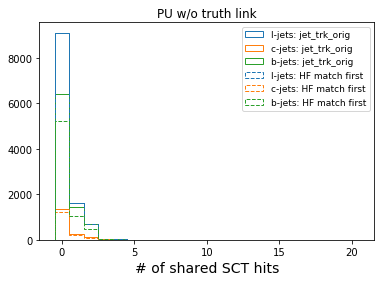

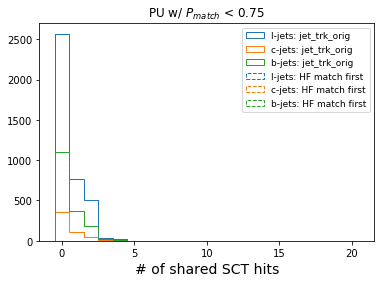

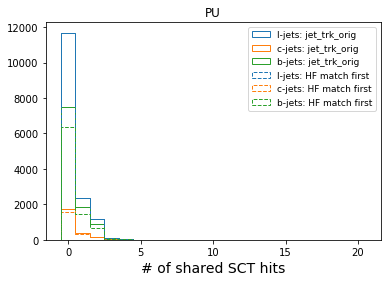

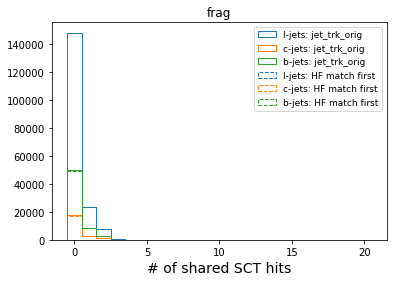

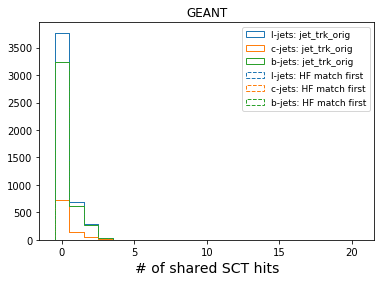

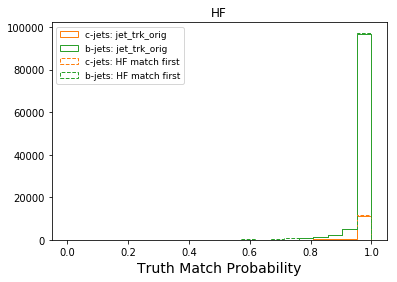

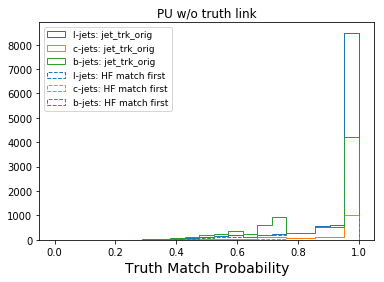

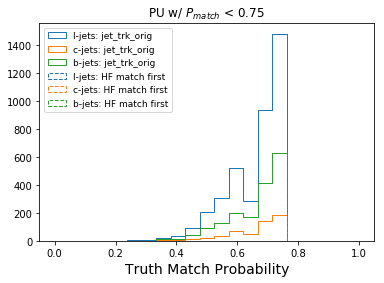

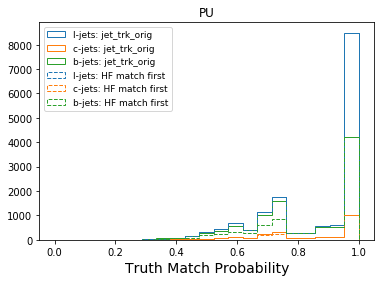

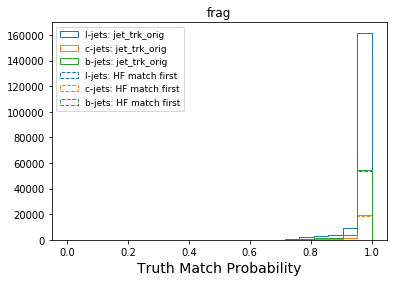

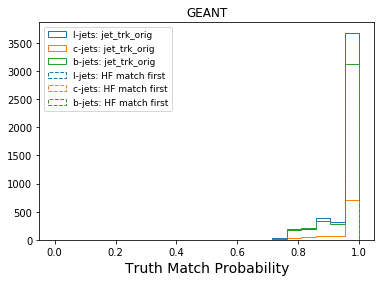

In [15]:
for v, xlabel, nBins, myRange, loc in zip(xr_vars,xlabels,var_bins,var_ranges,legend_loc):

    # Access the non-masked trks in the jet for this trk feature
    var = trk_xr.loc[:,:,v].values[mask]
            
    for oi, orig_label, orig_tag in zip([0,-1,1,(-1,1),2,3],
                                    ['HF','PU w/o truth link','PU w/ $P_{match}$ < 0.75','PU','frag','GEANT'],
                                    ['HF','PU_noTruth','PU_truthLink','PU','frag','GEANT']):
    
        plt.figure()
    
        for o_trks, subDir, text, l in zip([o1_trks, o2_trks],
                                           ['mc16d_Topo_ttbar','newTrkLabel'],
                                           ['jet_trk_orig','HF match first'], 
                                           ['-','--']):

            
            # Get the mask for the track origin
            if type(oi) == tuple:
                orig_mask = np.zeros_like(y_trks).astype(bool)
                for oix in oi:
                    orig_mask = orig_mask | (o_trks==oix)
            else:
                orig_mask = (o_trks==oi)

            for yi, flav in zip(range(3), ['l','c','b']):

                if (yi == 0) and (oi == 0):
                    continue
                
                plt.hist(var[orig_mask & (y_trks == yi)],
                         range=myRange,bins=nBins,
                         histtype='step', #density=True, 
                         color='C{}'.format(yi), linestyle=l,
                         label='{}-jets: {}'.format(flav,text))

        
        plt.legend(loc=loc,fontsize=9)  
        plt.xlabel(xlabel,fontsize=14)  
        plt.title(orig_label)
        plt.savefig('../../figures/newTrkLabel/{}_{}_cf_orig.pdf'.format(v,orig_tag))

        # Also save d0 w/ the log scale
        if v == 'ip3d_d0':
            plt.yscale('log', nonposy='clip')
            plt.savefig('../../figures/newTrkLabel/{}_{}_cf_orig_log.pdf'.format(v,orig_tag))

        plt.show()

**Step 2:** Probe the correlation of the # of shared hits w/ the truth match prob to see if tracks are more likely to be shared in a dense enviornment.


(I'm not sure if this is a sensible plot to make, but I have some questions for Valentina about this variable, so if I try to understand it on my own, it will help me understand when she explains it to me!)

Maybe I should start by just plotting the # of shared Si hits vs the truth match prob?

I think I should be 20 of these plots: so break them down by (...) and (...)

Since I've been doing my other shared hits studies w/ the `jet_trk_orig` variable, I'm going to be using this var for the trk labelling here as well.

**Step 3:** Let's look at the $n_{trk}$ distributions broken down be origin for these two definitions of the track origin.

Loop through the particles and 

In [19]:
trk_xr.coords['var']

<xarray.DataArray 'var' (var: 24)>
array(['sd0', 'sz0', 'ip3d_d0', 'parent_pdgid', 'pdg_id', 'barcode',
       'ip3d_grade', 'orig', 'pt', 'eta', 'phi', 'nInnHits', 'nNextToInnHits',
       'nsharedBLHits', 'nsplitBLHits', 'nPixHits', 'nsharedPixHits',
       'nsplitPixHits', 'nSCTHits', 'nsharedSCTHits', 'truthProb', 'newLabel',
       'newOrig', 'newOrig_0.5'], dtype=object)
Coordinates:
  * var      (var) object 'sd0' 'sz0' 'ip3d_d0' ... 'newOrig' 'newOrig_0.5'

In [34]:
for trkTag in ['','_0.5']:
    
    key = 'newOrig' + trkTag
    trk_origs = trk_xr.loc[:,:,key].values
    
    for oi, orig_label, orig_tag in zip([0,-1,1,2,3],
                                        ['HF','PU w/o truth link','PU w/ $P_{match}$ < 0.75','frag','GEANT'],
                                        ['HF','PU_noTruth','PU_truthLink','frag','GEANT']):

        
        orig_mask = (trk_origs == oi)
        
        trkExists = (np.sum(X, axis=-1) != 0)
        orig_mask = orig_mask & trkExists
        
        key = 'ip3d_ntrk' + trkTag + '_' + orig_tag
        jet_df[key] = np.sum(orig_mask, axis=-1)

In [35]:
jet_df.head()

pt       eta  aliveAfterOR  aliveAfterORmu       JVT  LabDr_HadF  \
0   68.893227 -0.759664           1.0             1.0  0.991884         0.0   
1   25.233934 -0.981017           1.0             1.0  0.948471         0.0   
2  145.925094 -0.716755           1.0             1.0  0.987831         5.0   
3  117.317711 -0.599926           1.0             1.0  0.995089         0.0   
4   79.588578  2.121990           1.0             1.0  0.987135         0.0   

      pt_orig  eta_orig  phi_orig  nBHadr         ...           ip3d_ntrk_HF  \
0   64.863020 -0.759754 -0.344617     0.0         ...                      0   
1   24.388150 -0.979740  0.144666     0.0         ...                      0   
2  140.655969 -0.716697 -3.139154     1.0         ...                      1   
3  111.388484 -0.599883  2.323595     0.0         ...                      0   
4   79.977961  2.122289 -1.868791     0.0         ...                      0   

   ip3d_ntrk_PU_noTruth  ip3d_ntrk_PU_truthLink  ip3d_ntrk_frag  \
0                     0                       0               6   
1                     0                       0               4   
2                     0                       0               4   
3                     3                       0               4   
4                     0                       0               3   

   ip3d_ntrk_GEANT  ip3d_ntrk_0.5_HF  ip3d_ntrk_0.5_PU_noTruth  \
0                2                 0                         0   
1                0                 0                         0   
2                0                 1                         0   
3                3                 0                         3   
4                0                 0                         0   

   ip3d_ntrk_0.5_PU_truthLink  ip3d_ntrk_0.5_frag  ip3d_ntrk_0.5_GEANT  
0                           0                   6                    2  
1                           0                   4                    0  
2                           0                   4                    0  
3                           0                   4                    3  
4                           0                   3                    0  

[5 rows x 24 columns]

In [40]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    print('\n{}-jets:'.format(flav))
    mask = (jet_df.LabDr_HadF == pdg)
    
    # Note: Not barcode matched
    for trkTag in ['newOrig','newOrig_0.5']:
    
        key = 'jet_trk_' + trkTag
        print("  " + trkTag)
    
        for orig_tag in ['HF','PU_noTruth','PU_truthLink','frag','GEANT']:

            key = 'ip3d_ntrk_' + orig_tag
            print("    {} = {:.2f}".format(orig_tag, jet_df.loc[mask,key].mean()))


l-jets:
  newOrig
    HF = 0.00
    PU_noTruth = 0.27
    PU_truthLink = 0.09
    frag = 4.26
    GEANT = 0.11
  newOrig_0.5
    HF = 0.00
    PU_noTruth = 0.27
    PU_truthLink = 0.09
    frag = 4.26
    GEANT = 0.11

c-jets:
  newOrig
    HF = 1.72
    PU_noTruth = 0.25
    PU_truthLink = 0.07
    frag = 2.97
    GEANT = 0.13
  newOrig_0.5
    HF = 1.72
    PU_noTruth = 0.25
    PU_truthLink = 0.07
    frag = 2.97
    GEANT = 0.13

b-jets:
  newOrig
    HF = 3.39
    PU_noTruth = 0.28
    PU_truthLink = 0.05
    frag = 1.97
    GEANT = 0.13
  newOrig_0.5
    HF = 3.39
    PU_noTruth = 0.28
    PU_truthLink = 0.05
    frag = 1.97
    GEANT = 0.13


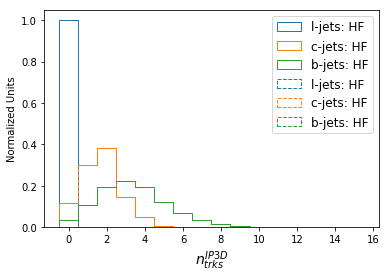

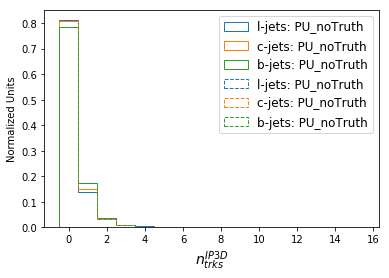

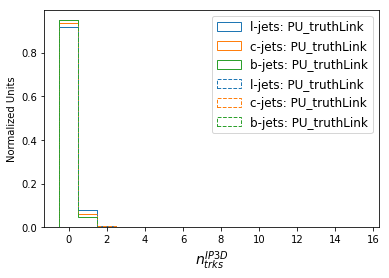

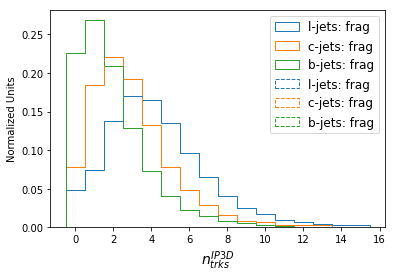

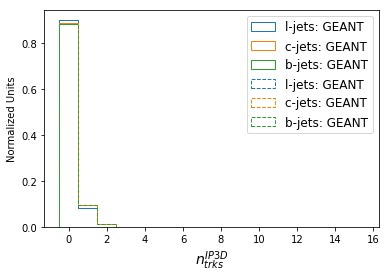

In [44]:
for i, orig_tag in enumerate(['HF','PU_noTruth','PU_truthLink','frag','GEANT']):
   
    for Pmatch, l in zip([0.75, 0.5],['-','--']):
    
        key = 'ip3d_ntrk_' + orig_tag
        plt.figure(i)

        for yi, pdg, flav in zip(range(3), [0,4,5],['l','c','b']):

            mask = (jet_df.LabDr_HadF == pdg)

            plt.hist(jet_df.loc[mask,key],range=(-0.5,15.5),bins=16,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,orig_tag))

        plt.legend(fontsize=12)   
        plt.xlabel('$n_{trks}^{IP3D}$',fontsize=14)
        plt.ylabel('Normalized Units')
#         plt.savefig("{}/ip3d_ntrks_{}.pdf".format(figDir,orig_tag),
#                     bbox_inches='tight')
plt.show()        